`Task formulation`:<br>
Turnover analytics, followed by detailed analytical report on the sellers and products listed on the marketplace. 
## Contents
`Turnover Analytics:` <br>
* Aggregated turnover (forecast included),
* Turnover in categories,
* Growing Categories,
* Most valuable categories,
* Declining Categories,
* Least valuable categories.<br>

`Sellers Analytics:` <br>
* Sellers by Revenue stats,
* Best seller within each category,
* Sellers present across categories,
* Sellers by Customer Reviews and Scores.<br>

`Products Analytics:` <br>
* Products by Revenue and Quantity,
* Best product within each category,
* Categories described by characteristics of its products,
* Products popularity across sellers,
* Products by Customer Reviews and Scores.

# 1) Data overview
`Data Quality`<br>
Careful review of `Data Card` and `Data Explorer` associated with `transactional_data.sqlite` reveals two minor issues with this data:
* `orders.timestamp` is VARCHAR
* Couple of missing values for `products.product_weight_g`<br>

`SQL Alchemy`<br>
SQLAlchemy is a Python library that allows you to leverage DBMS efficiency and interact with databases conveniently from within your notebook. It supports multiple Database Management Systems (DBMSs), including SQLite, PostgreSQL, MySQL, and Oracle.

In [1]:
from sqlalchemy import create_engine, inspect, text

# Create a database engine
engine = create_engine('sqlite:////home/petewojtczak/databases/transactional_data.sqlite')
# simplified schema and tables info
with engine.connect() as conn:
    inspector = inspect(engine)    
    for table_name in inspector.get_table_names():
        # Retrieve column information
        columns_info = inspector.get_columns(table_name)
        columns = [col['name'] for col in columns_info]        
        # Check for primary key
        primary_key = next((col['name'] for col in columns_info if col['primary_key']), None)        
        # Check for foreign keys
        foreign_keys_info = inspector.get_foreign_keys(table_name)
        foreign_key_columns = [fk['constrained_columns'][0] for fk in foreign_keys_info]        
        # Count the number of records in the table
        num_records_query = text(f"SELECT COUNT(*) FROM '{table_name}'")
        num_records = conn.execute(num_records_query).scalar()        
        # Print results
        print(f"\n\033[1m'{table_name}'\033[0m")
        print(f"Number of Records: {num_records}")
        print(f"Columns: {columns}")
        print(f"Primary Key: {primary_key}")
        if foreign_key_columns:
            print("Foreign Key Column(s):")
            for fk_column in foreign_key_columns:
                print(f"  - {fk_column}")
        else:
            print("Foreign Key: None")


'order_items'
Number of Records: 110197
Columns: ['order_items_pk', 'order_id', 'product_id', 'seller_id', 'price']
Primary Key: order_items_pk
Foreign Key Column(s):
  - order_id
  - product_id
  - seller_id

'order_reviews'
Number of Records: 39462
Columns: ['review_id', 'order_id', 'review_score', 'review_comment_message', 'sentiment', 'text_rating']
Primary Key: review_id
Foreign Key Column(s):
  - order_id

'orders'
Number of Records: 96478
Columns: ['order_id', 'timestamp', 'customer_contact']
Primary Key: order_id
Foreign Key: None

'products'
Number of Records: 32216
Columns: ['product_id', 'product_category_name', 'product_weight_g']
Primary Key: product_id
Foreign Key: None

'sellers'
Number of Records: 2970
Columns: ['seller_id', 'seller_state']
Primary Key: seller_id
Foreign Key: None


`orders`<br>
Provides details about each order.<br>
**Columns description**:
* `order_id`; PK, unique identifier of the order(VARCHAR),<br>
* `timestamp`; shows the purchase timestamp (VARCHAR),<br> 
* `customer_contact`; unique identifier of the consumer (VARCHAR).

`order_items`<br>
Serves as a container for a set of items associated with each order.<br>
**Columns description**:
* `order_items_pk`; PK, row unique identifier (INTEGER).<br>
* `order_id`; FK, order unique identifier (VARCHAR).<br>
* `product_id`; FK, product unique identifier (VARCHAR).<br>
* `seller_id`; FK, seller unique identifier (VARCHAR).<br>
* `price`; item price (FLOAT).

`products`<br>
 Products available on the marketplace.<br>
**Columns description**:
* `product_id`; PK, product unique identifier (VARCHAR),<br>
* `product_category_name`; root category of product, in Portuguese (VARCHAR),<br>
* `product_weight_g`; product weight measured in grams (FLOAT).

`sellers`<br>
Contains information about sellers.<br>
**Columns description**:
* `seller_id`; PK, seller unique identifier (VARCHAR).<br>
* `seller_state`; state of the seller (VARCHAR).<br>

`order_reviews`<br>
Includes text reviews and star rating associated with each order.<br>
**Columns description**:
* `review_id`; PK, unique review identifier(VARCHAR).<br>
* `order_id`; FK, order unique identifier(VARCHAR).<br>
* `review_score`; note ranging from 1 to 5 given by the customer on a satisfaction survey(INTEGER).<br>
* `review_comment_message`; comment message from the review left by the customer, in Portuguese (VARCHAR).<br>

# 2) Turnover analytics

In [2]:
import pandas as pd
import numpy as np

def ts_cleaning(ts):
    # data cleaning procedures
    ts['order_date'] = pd.to_datetime(ts['order_date'])
    ts.set_index('order_date', inplace=True)
    full_index = pd.date_range(start=ts.index.min(), end=ts.index.max(), freq='D')
    ts = ts.reindex(full_index, fill_value=0)
    ts.index.name = 'order_date'
    return ts

`Geography`<br>
Majority of the business is located in the state of 'SP'.

In [3]:
query = """
SELECT 
    s.seller_state AS state,
    SUM(oi.price) AS total_sales,
    (SUM(oi.price) / (SELECT SUM(price) FROM order_items) * 100) AS sales_share_pct
FROM 
    order_items oi
JOIN 
    sellers s ON oi.seller_id = s.seller_id
GROUP BY 
    s.seller_state
ORDER BY 
    total_sales DESC;
"""
pd.read_sql_query(query, engine).set_index('state').round(2).head(10)

,total_sales,sales_share_pct
state,,
SP,8509511.46,64.36
PR,1232096.99,9.32
MG,977866.31,7.40
RJ,820611.59,6.21
SC,613591.65,4.64
RS,373412.08,2.82
BA,277925.51,2.10
DF,94840.31,0.72
PE,91164.15,0.69


## Aggregated turnover

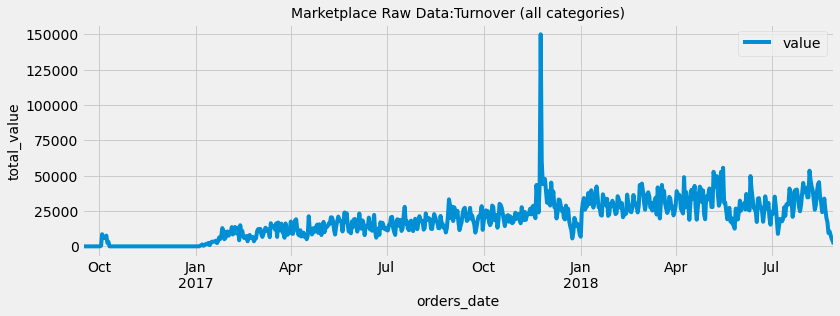

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

 # order_date is a VARCHAR, but in SQLite it behaves as a date for ordering and grouping
all_categories_turnover = f"""
        SELECT
            date(o.timestamp) AS order_date,
            SUM(oi.price) AS value
        FROM orders o 
        JOIN order_items oi ON o.order_id = oi.order_id
        JOIN products p ON oi.product_id = p.product_id
        GROUP BY date(o.timestamp)
        ORDER BY order_date
    """
# data retrival and cleaning
marketplace_turnover = pd.read_sql_query(all_categories_turnover, engine)
marketplace_turnover = ts_cleaning(marketplace_turnover)
# plotting
ax = marketplace_turnover.plot(figsize=(12, 4))
ax.set_title('Marketplace Raw Data:Turnover (all categories)', fontsize=14)
ax.set_xlabel('orders_date', fontsize=14)
ax.set_ylabel('total_value', fontsize=14)
plt.show()

* `Sparse data` linked to the initial stages of activity,
*  An `outlier` with a total value reaching as high as 150k (`2017-11-24`),
* A `sudden drop in turnover` in the last few days.

`Sparse Data`<br>
To mitigate issues with sparse data, we will set 2017-02-01 as the starting date for the model.<br>
`Outlier`<br>
A single outlier data point will be replaceed with the mean of its two nearest data points.<br>
`Sudden Drop in Turnover`<br>
This issue is also somewhat related to sparse data at the end of the time series. Since we expect a forecasting horizon of 14 days, we will exclude the 7 most recent (and potentially suspicious) data points from our datasets, while extending our forecasting horizon to 21 days. It’s important to note that sklearn algos learn patterns from historical data to make predictions. If a sudden shock event occurs, the model is not a magic solution and will likely be unable to account for it accurately. Here, we are essentially assuming that no shock event has occurred and are disregarding the latest few data points to presumably avoid skewing the predictions.

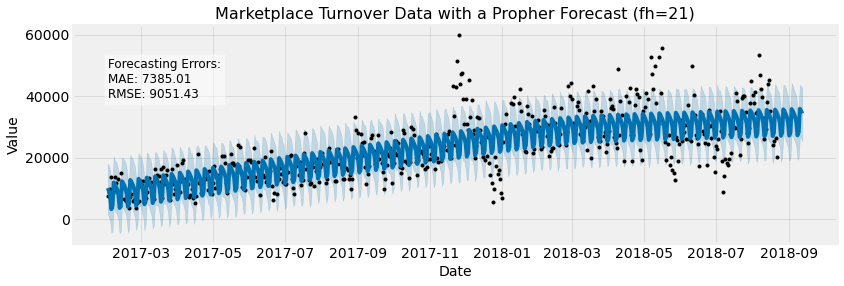

CPU times: user 3.12 s, sys: 191 ms, total: 3.31 s
Wall time: 3.12 s


In [5]:
%%time
import logging
import warnings
from fbprophet import Prophet
# Suppress INFO logging for Prophet
logging.getLogger('fbprophet').setLevel(logging.ERROR)
# Suppress FutureWarnings from pandas
warnings.simplefilter(action='ignore', category=FutureWarning)

def Prophet_prep(ts):
    ts = ts.copy()
    ts.reset_index(inplace=True)
    ts.rename(columns={'order_date': 'ds', 'value': 'y'}, inplace=True)
    return ts

# raw data cleaning
marketplace_turnover = marketplace_turnover.copy()
marketplace_turnover = marketplace_turnover['2017-02-01':'2018-08-22']
new_value = (marketplace_turnover.loc['2017-11-23', 'value'] + 
             marketplace_turnover.loc['2017-11-25', 'value']) / 2
marketplace_turnover.loc['2017-11-24', 'value'] = new_value
# Split data into training and test sets
y_train = marketplace_turnover.iloc[:len(marketplace_turnover) - 21]
y_test = marketplace_turnover.iloc[len(marketplace_turnover) - 21:]
# Fit the model on training data
model = Prophet()
model.fit(Prophet_prep(y_train))
# Make predictions for the test period to calculate forecasting errors
fcst_df = model.make_future_dataframe(periods=21)
fcst = model.predict(fcst_df)
# Calculate forecasting errors
MAE = np.mean(np.abs(y_test.value.values - fcst.yhat.tail(21).values))
RMSE = np.sqrt(np.mean((y_test.value.values - fcst.yhat.tail(21).values) ** 2))
# Refit the model on the entire dataset
model = Prophet()
model.fit(Prophet_prep(marketplace_turnover))
# Forecast for the next 21 days
future = model.make_future_dataframe(periods=21)
forecast = model.predict(future)
# Plot forecast
fig = model.plot(forecast, figsize=(12, 4))
plt.title('Marketplace Turnover Data with a Propher Forecast (fh=21)', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.text(
    x=forecast.ds.min(),  
    y=forecast.yhat.max()*1.1,
    s=f"Forecasting Errors:\nMAE: {MAE:.2f}\nRMSE: {RMSE:.2f}",
    fontsize=12,
    bbox=dict(facecolor='white', alpha=0.5)
)
plt.show()

In [6]:
# Volatile time-series data
print(f'MAE: {MAE}')
print(f'RMSE: {RMSE}')
print(f'AVG(forecast_value): {forecast.yhat.tail(21).mean()}')

MAE: 7385.007199531527
RMSE: 9051.427042695335
AVG(forecast_value): 32149.189491868074


## Turnover in categories
We will calculate the `slope coefficient for each category` to better understand the turnover and trends within each category. Some restrictions apply to account for frequency issues. Note that linear regression is sensitive to outliers and sparse data. In order to spot the categories that pulls the turnover delta in both directions reasonably, `starting date for slope calcuation` is `2018-01-01`.
<br><br>
`Tangible interpretation`:<br>
The value of the considered category, on average, changes daily by the amount represented by `slope coefficient`.

In [7]:
distinct_categories = """
SELECT 
    COUNT(DISTINCT product_category_name) AS distinct_category_count
FROM 
    products
"""
pd.read_sql_query(distinct_categories, engine)

,distinct_category_count
0,74


`LinearRegression`

In [8]:
%%time
from sklearn.linear_model import LinearRegression

query = """
SELECT 
    p.product_category_name, 
    SUM(oi.price) AS total_worth, 
    COUNT(oi.order_items_pk) AS total_items_sold
FROM 
    products p 
JOIN 
    order_items oi ON p.product_id = oi.product_id
GROUP BY 
    p.product_category_name
ORDER BY 
    total_worth DESC
"""
categories_summary = pd.read_sql_query(query, engine)
categories_summary.set_index('product_category_name', inplace=True)

for category in categories_summary.index:
    # ghost category
    if category=='seguros_e_servicos':
        continue
    query = f"""
    SELECT 
        DATE(o.timestamp) AS order_date,
        SUM(oi.price) AS value
    FROM 
        orders o
    JOIN 
        order_items oi ON o.order_id = oi.order_id
    JOIN 
        products p ON oi.product_id = p.product_id
    WHERE 
        p.product_category_name = '{category}' 
        AND DATE(o.timestamp) BETWEEN '2018-01-01' AND '2018-08-22'
    GROUP BY 
        date(o.timestamp)
    ORDER BY 
        order_date
    """
    # data retrival and cleaning
    ts = pd.read_sql_query(query, engine)
    ts = ts_cleaning(ts)
    # at least 30 data points in the sample
    if (ts.value!=0).sum() < 30:
        continue
    # training
    X = np.arange(len(ts)).reshape(-1, 1)
    y = ts['value'].values
    model = LinearRegression()
    model.fit(X, y)
    # slope_coeff collection
    categories_summary.loc[category, 'slope_coeff'] = model.coef_[0]

CPU times: user 55.7 s, sys: 9.63 s, total: 1min 5s
Wall time: 21.1 s


`Categories growing` since 2018

In [9]:
categories_summary.sort_values(by='slope_coeff', ascending=False).round(2).head(10)

,total_worth,total_items_sold,slope_coeff
product_category_name,,,
beleza_saude,1233131.72,9465,7.84
utilidades_domesticas,615628.69,6795,6.04
relogios_presentes,1166176.98,5859,3.52
telefonia,309860.23,4430,3.48
pet_shop,211695.64,1924,2.44
construcao_ferramentas_construcao,142108.49,916,2.24
automotivo,578966.65,4140,1.71
pcs,218684.14,199,1.65
perfumaria,390144.65,3340,1.19


`Most valuable categories`

In [10]:
categories_summary.round(2).head(10)

,total_worth,total_items_sold,slope_coeff
product_category_name,,,
beleza_saude,1233131.72,9465,7.84
relogios_presentes,1166176.98,5859,3.52
cama_mesa_banho,1023434.76,10953,-0.54
esporte_lazer,954852.55,8431,-5.49
informatica_acessorios,888724.61,7644,-8.91
moveis_decoracao,711927.69,8160,-0.31
utilidades_domesticas,615628.69,6795,6.04
cool_stuff,610204.10,3718,-3.23
automotivo,578966.65,4140,1.71


`Categories in decline` since 2018

In [11]:
categories_summary.sort_values(by='slope_coeff', ascending=True).round(2).head(10)

,total_worth,total_items_sold,slope_coeff
product_category_name,,,
informatica_acessorios,888724.61,7644,-8.91
esporte_lazer,954852.55,8431,-5.49
cool_stuff,610204.10,3718,-3.23
unknown_category,170726.63,1537,-2.94
moveis_escritorio,268154.31,1668,-1.88
papelaria,223788.69,2466,-1.69
malas_acessorios,138701.63,1077,-1.14
bebes,400421.84,2982,-1.07
eletronicos,155043.93,2729,-0.74


`Least valuable categories`

In [12]:
categories_summary.tail(5)

,total_worth,total_items_sold,slope_coeff
product_category_name,,,
flores,1110.04,33,NaN
casa_conforto_2,760.27,30,NaN
cds_dvds_musicais,730.00,14,NaN
fashion_roupa_infanto_juvenil,519.95,7,NaN
seguros_e_servicos,283.29,2,NaN


# 3) Sellers analytics

`Sellers by Revenue`

In [13]:
query = """
-- Step 1: Calculate total revenue and average daily revenue
WITH revenue_data AS (
    SELECT 
        s.seller_id,
        s.seller_state AS state,
        SUM(oi.price) AS total_revenue,
        SUM(oi.price) / (SELECT COUNT(DISTINCT DATE(timestamp)) FROM orders) AS average_daily_revenue
    FROM 
        sellers s
    JOIN 
        order_items oi ON s.seller_id = oi.seller_id
    GROUP BY 
        s.seller_id,
        s.seller_state
),

-- Step 2: Calculate average order value per seller
avg_order_data AS (
    SELECT
        s.seller_id,
        AVG(order_total) AS avg_order_value
    FROM 
        sellers s
    JOIN (
        SELECT 
            oi.seller_id,
            oi.order_id,
            SUM(oi.price) AS order_total
        FROM 
            order_items oi
        GROUP BY 
            oi.seller_id, oi.order_id
    ) AS order_totals ON s.seller_id = order_totals.seller_id
    GROUP BY 
        s.seller_id
)

-- Step 3: Combine the results
SELECT 
    rd.seller_id,
    rd.state,
    rd.total_revenue,
    rd.average_daily_revenue,
    aod.avg_order_value
FROM 
    revenue_data rd
JOIN 
    avg_order_data aod ON rd.seller_id = aod.seller_id
ORDER BY 
    rd.total_revenue DESC
LIMIT 10;
"""
pd.read_sql_query(query, engine).round(2)

,seller_id,state,total_revenue,average_daily_revenue,avg_order_value
0,4869f7a5dfa277a7dca6462dcf3b52b2,SP,226987.93,370.90,201.95
1,53243585a1d6dc2643021fd1853d8905,BA,217940.44,356.11,626.27
2,4a3ca9315b744ce9f8e9374361493884,SP,196882.12,321.70,111.11
3,fa1c13f2614d7b5c4749cbc52fecda94,SP,190917.14,311.96,330.31
4,7c67e1448b00f6e969d365cea6b010ab,SP,186570.05,304.85,191.75
5,7e93a43ef30c4f03f38b393420bc753a,SP,165981.49,271.21,520.32
6,da8622b14eb17ae2831f4ac5b9dab84a,SP,159816.87,261.14,121.90
7,7a67c85e85bb2ce8582c35f2203ad736,SP,139658.69,228.20,121.97
8,1025f0e2d44d7041d6cf58b6550e0bfa,SP,138208.56,225.83,151.88
9,955fee9216a65b617aa5c0531780ce60,SP,131836.71,215.42,104.55


`Best seller within each category`

In [14]:
query = """
WITH ranked_sellers AS (
    SELECT 
        p.product_category_name,
        oi.seller_id,
        SUM(oi.price) AS seller_revenue,
        RANK() OVER (PARTITION BY p.product_category_name ORDER BY SUM(oi.price) DESC) AS seller_rank
    FROM 
        order_items oi
    JOIN 
        products p ON oi.product_id = p.product_id
    GROUP BY 
        p.product_category_name, oi.seller_id
)

SELECT 
    product_category_name,
    seller_id,
    seller_revenue
FROM 
    ranked_sellers
WHERE 
    seller_rank = 1
ORDER BY 
    seller_revenue DESC
"""
pd.read_sql_query(query, engine).head(10)

,product_category_name,seller_id,seller_revenue
0,relogios_presentes,4869f7a5dfa277a7dca6462dcf3b52b2,198822.03
1,moveis_escritorio,7c67e1448b00f6e969d365cea6b010ab,171605.82
2,pcs,53243585a1d6dc2643021fd1853d8905,163322.76
3,cama_mesa_banho,4a3ca9315b744ce9f8e9374361493884,162206.95
4,cool_stuff,7a67c85e85bb2ce8582c35f2203ad736,133408.69
5,moveis_decoracao,1025f0e2d44d7041d6cf58b6550e0bfa,110770.46
6,ferramentas_jardim,1f50f920176fa81dab994f9023523100,102849.61
7,brinquedos,46dc3b2cc0980fb8ec44634e21d2718e,79337.07
8,beleza_saude,edb1ef5e36e0c8cd84eb3c9b003e486d,79144.90
9,papelaria,3d871de0142ce09b7081e2b9d1733cb1,78894.80


`Sellers present across categories`

In [15]:
query = """
SELECT 
    s.seller_id,
    s.seller_state,
    COUNT(DISTINCT p.product_category_name) AS category_count,
    SUM(oi.price) AS total_revenue
FROM 
    sellers s
JOIN 
    order_items oi ON s.seller_id = oi.seller_id
JOIN 
    products p ON oi.product_id = p.product_id
GROUP BY 
    s.seller_id, s.seller_state
ORDER BY 
    category_count DESC, total_revenue DESC
"""
pd.read_sql_query(query, engine).head(10)

,seller_id,seller_state,category_count,total_revenue
0,b2ba3715d723d245138f291a6fe42594,SP,27,49302.18
1,4e922959ae960d389249c378d1c939f5,SP,24,45338.42
2,955fee9216a65b617aa5c0531780ce60,SP,23,131836.71
3,1da3aeb70d7989d1e6d9b0e887f97c23,SP,21,8691.56
4,f8db351d8c4c4c22c6835c19a46f01b0,SP,20,50082.60
5,18a349e75d307f4b4cc646a691ed4216,SP,17,7425.21
6,70a12e78e608ac31179aea7f8422044b,SP,15,29963.53
7,44073f8b7e41514de3b7815dd0237f4f,DF,15,18380.64
8,6edacfd9f9074789dad6d62ba7950b9c,SP,15,12966.40
9,7178f9f4dd81dcef02f62acdf8151e01,SC,14,36795.40


`Sellers by Customer Reviews and Scores`

In [16]:
query = """
SELECT 
    s.seller_id,
    s.seller_state,
    AVG(r.review_score) AS avg_review_score,
    COUNT(r.review_id) AS review_count
FROM 
    sellers s
JOIN 
    order_items oi ON s.seller_id = oi.seller_id
JOIN 
    order_reviews r ON oi.order_id = r.order_id
WHERE 
    r.review_score IS NOT NULL
GROUP BY 
    s.seller_id, s.seller_state
HAVING 
    review_count >= 50  -- Only consider sellers with a reasonable number of reviews
ORDER BY 
    avg_review_score DESC
"""
pd.read_sql_query(query, engine).head(10).round(2)

,seller_id,seller_state,avg_review_score,review_count
0,12b9676b00f60f3b700e83af21824c0e,RS,4.47,66
1,6cd68b3ed6d59aaa9fece558ad360c0a,MG,4.40,62
2,cab85505710c7cb9b720bceb52b01cee,SP,4.33,86
3,fe2032dab1a61af8794248c8196565c9,SP,4.26,133
4,7e93a43ef30c4f03f38b393420bc753a,SP,4.24,144
5,c003204e1ab016dfa150abc119207b24,SP,4.23,88
6,2a84855fd20af891be03bc5924d2b453,MG,4.21,66
7,fa40cc5b934574b62717c68f3d678b6d,SP,4.18,125
8,37be5a7c751166fbc5f8ccba4119e043,SP,4.17,155
9,fa1c13f2614d7b5c4749cbc52fecda94,SP,4.14,261


# 4) Products analytics

`Products by Revenue and Quantity`

In [17]:
query = """
SELECT 
    p.product_id,
    p.product_category_name,
    SUM(oi.price) AS total_revenue,
    SUM(oi.price) / (SELECT COUNT(DISTINCT DATE(timestamp)) FROM orders) AS avg_daily_revenue,
    COUNT(oi.order_items_pk) AS total_units_sold
FROM 
    products p
JOIN 
    order_items oi ON p.product_id = oi.product_id
JOIN 
    orders o ON oi.order_id = o.order_id
GROUP BY 
    p.product_id, p.product_category_name
ORDER BY 
    avg_daily_revenue DESC
"""
pd.read_sql_query(query, engine).head(10)

,product_id,product_category_name,total_revenue,avg_daily_revenue,total_units_sold
0,bb50f2e236e5eea0100680137654686c,beleza_saude,63560.00,103.856209,194
1,6cdd53843498f92890544667809f1595,beleza_saude,53652.30,87.667157,153
2,d6160fb7873f184099d9bc95e30376af,pcs,45949.35,75.080637,33
3,d1c427060a0f73f6b889a5c7c61f2ac4,informatica_acessorios,45620.56,74.543399,332
4,99a4788cb24856965c36a24e339b6058,cama_mesa_banho,42049.66,68.708595,477
5,3dd2a17168ec895c781a9191c1e95ad7,informatica_acessorios,40782.80,66.638562,272
6,25c38557cf793876c5abdd5931f922db,bebes,38907.32,63.574052,38
7,5f504b3a1c75b73d6151be81eb05bdc9,cool_stuff,37733.90,61.656699,63
8,53b36df67ebb7c41585e8d54d6772e08,relogios_presentes,37454.63,61.200376,321
9,aca2eb7d00ea1a7b8ebd4e68314663af,moveis_decoracao,37104.30,60.627941,520


`Best product within each category`

In [18]:
query = """
WITH ranked_products AS (
    SELECT 
        p.product_category_name,
        oi.product_id,
        SUM(oi.price) AS product_revenue,
        RANK() OVER (PARTITION BY p.product_category_name ORDER BY SUM(oi.price) DESC) AS product_rank
    FROM 
        order_items oi
    JOIN 
        products p ON oi.product_id = p.product_id
    GROUP BY 
        p.product_category_name, oi.product_id
)

SELECT 
    product_category_name,
    product_id,
    product_revenue
FROM 
    ranked_products
WHERE 
    product_rank = 1
ORDER BY 
    product_revenue DESC
"""
pd.read_sql_query(query, engine).head(15)

,product_category_name,product_id,product_revenue
0,beleza_saude,bb50f2e236e5eea0100680137654686c,63560.00
1,pcs,d6160fb7873f184099d9bc95e30376af,45949.35
2,informatica_acessorios,d1c427060a0f73f6b889a5c7c61f2ac4,45620.56
3,cama_mesa_banho,99a4788cb24856965c36a24e339b6058,42049.66
4,bebes,25c38557cf793876c5abdd5931f922db,38907.32
5,cool_stuff,5f504b3a1c75b73d6151be81eb05bdc9,37733.90
6,relogios_presentes,53b36df67ebb7c41585e8d54d6772e08,37454.63
7,moveis_decoracao,aca2eb7d00ea1a7b8ebd4e68314663af,37104.30
8,ferramentas_jardim,422879e10f46682990de24d770e7f83d,26577.22
9,instrumentos_musicais,16c4e87b98a9370a9cbc3a4658a3f45b,25034.00


`Categories described by characteristics of its products`

In [19]:
query = """
SELECT 
    p.product_category_name,
    AVG(oi.price) AS avg_product_price,
    AVG(p.product_weight_g) AS avg_product_weight,
    AVG(orv.review_score) AS avg_review_score
FROM 
    products p
JOIN 
    order_items oi ON p.product_id = oi.product_id
LEFT JOIN 
    order_reviews orv ON oi.order_id = orv.order_id
GROUP BY 
    p.product_category_name
ORDER BY 
    avg_product_price DESC;
"""
pd.read_sql_query(query, engine).head(10).round(2)

,product_category_name,avg_product_price,avg_product_weight,avg_review_score
0,pcs,1098.92,7203.32,3.97
1,portateis_casa_forno_e_cafe,638.21,5010.85,4.17
2,eletrodomesticos_2,467.33,8926.14,3.78
3,agro_industria_e_comercio,342.55,3683.13,3.57
4,instrumentos_musicais,283.13,3134.54,3.82
5,portateis_cozinha_e_preparadores_de_alimentos,280.97,2996.43,3.22
6,eletroportateis,277.23,2938.93,3.85
7,telefonia_fixa,216.92,559.36,3.26
8,construcao_ferramentas_seguranca,211.88,813.92,3.38
9,relogios_presentes,199.02,584.01,3.66


`Products popularity across sellers`

In [20]:
query = """
SELECT 
    p.product_id,
    p.product_category_name,
    COUNT(DISTINCT oi.seller_id) AS seller_count
FROM 
    products p
JOIN 
    order_items oi ON p.product_id = oi.product_id
GROUP BY 
    p.product_id, p.product_category_name
ORDER BY 
    seller_count DESC
"""
pd.read_sql_query(query, engine).head(10)

,product_id,product_category_name,seller_count
0,69455f41626a745aea9ee9164cb9eafd,relogios_presentes,8
1,d285360f29ac7fd97640bf0baef03de0,relogios_presentes,8
2,36f60d45225e60c7da4558b070ce4b60,informatica_acessorios,7
3,4298b7e67dc399c200662b569563a2b2,informatica_acessorios,7
4,656e0eca68dcecf6a31b8ececfabe3e8,informatica_acessorios,7
5,dbb67791e405873b259e4656bf971246,informatica_acessorios,6
6,461f43be3bdf8844e65b62d9ac2c7a5a,relogios_presentes,5
7,53ea9da485f6aed8a6f03a85831fe021,relogios_presentes,5
8,7dd3fec3502f7ef333da2a73e00db394,perfumaria,5
9,be0dbdc3d67d55727a65d4cd696ca73c,informatica_acessorios,5


`Products by Customer Reviews and Scores`

In [21]:
query = """
SELECT 
    p.product_id,
    p.product_category_name,
    AVG(r.review_score) AS avg_review_score,
    COUNT(r.review_id) AS review_count
FROM 
    products p
JOIN 
    order_items oi ON p.product_id = oi.product_id
JOIN 
    order_reviews r ON oi.order_id = r.order_id
WHERE 
    r.review_score IS NOT NULL
GROUP BY 
    p.product_id, p.product_category_name
HAVING 
    review_count >= 50  -- Only consider products with a reasonable number of reviews
ORDER BY 
    avg_review_score DESC
"""
pd.read_sql_query(query, engine).head(10).round(2)

,product_id,product_category_name,avg_review_score,review_count
0,154e7e31ebfa092203795c972e5804a6,beleza_saude,4.28,108
1,f1c7f353075ce59d8a6f3cf58f419c9c,cama_mesa_banho,4.27,85
2,2028bf1b01cafb2d2b1901fca4083222,perfumaria,4.27,52
3,0aabfb375647d9738ad0f7b4ea3653b1,consoles_games,4.13,52
4,8c591ab0ca519558779df02023177f44,ferramentas_jardim,4.13,54
5,c6dd917a0be2a704582055949915ab32,cool_stuff,4.00,57
6,2b4609f8948be18874494203496bc318,beleza_saude,3.96,119
7,bb50f2e236e5eea0100680137654686c,beleza_saude,3.93,60
8,ec2d43cc59763ec91694573b31f1c29a,cama_mesa_banho,3.91,80
9,3dd2a17168ec895c781a9191c1e95ad7,informatica_acessorios,3.91,111
